In [2]:
import pandas as pd
import plotly.express as px

def get_model_para_bar(model):
    data = []
    xmap ={}
    for name,p in model.named_parameters():
        key = name.split(".")[0]
        if key not in xmap:xmap[key]=len(xmap)
        data.append([name+f".{tuple(p.shape)}",np.prod(p.shape),key])  
    names_col = ['layer','Log10_ParaM', 'block']
    plot_df = pd.DataFrame(data=data,columns=names_col)
    fig = px.bar(plot_df, x='block', y='Log10_ParaM', color='layer' ,title='My plot',height=600)
    fig.update_layout(showlegend=False) 
    fig.show()

In [3]:
metric_pool=[
"debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_12_step_10_07_22_57-seed_42",
"debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_1_step_10_07_12_53-seed_42",
"debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_2_step_10_05_00_07-seed_42",
"debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_3_step_10_03_11_51-seed_27468",
"debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_4_step_10_07_18_41-seed_42",
"debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_4_step_10_08_14_52-seed_42",
"debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_6_step_10_07_22_53-seed_42",
]

In [4]:
import torch,re

In [5]:
pattern = re.compile(r'2D70N_every_(.*)_step')   # 查找数字

In [6]:
data_pool={}
for path in metric_pool:
    time_intervel  = int(pattern.findall(path)[0])
    data_pool[time_intervel] = {}
    info_pool_list = torch.load(path)
    for info_pool in info_pool_list:
        for key, val in info_pool.items():
            if key not in data_pool[time_intervel]:data_pool[time_intervel][key]=[]
            data_pool[time_intervel][key].append(val)
        

FileNotFoundError: [Errno 2] No such file or directory: 'debug/WeathBench71_history_6_time_step_8_finetune-2D70N_every_12_step_10_07_22_57-seed_42'

In [ ]:
import numpy as np

In [ ]:
for time_intervel in data_pool.keys():
    for key, val in data_pool[time_intervel].items():
        data_pool[time_intervel][key] = np.array(val)

In [ ]:
from mltool.visualization import *

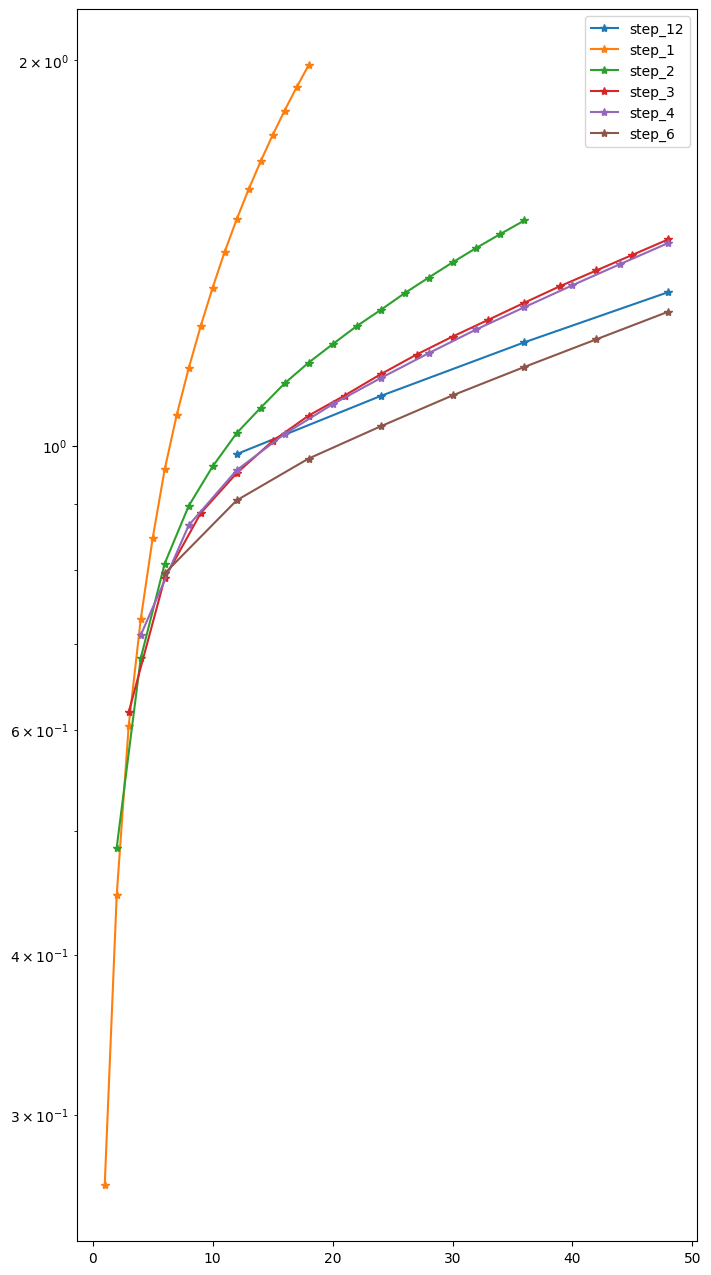

In [ ]:
%matplotlib inline
name = 'test_rmse_unit_850hPa_temperature'
fig = plt.figure(figsize=(8,16))
xmax = 50
xdata=np.arange(xmax)
ydata=np.arange(xmax)
for time_intervel in data_pool.keys():
    xdata= time_intervel*(np.arange(len(data_pool[time_intervel]['real_time']))+1)
    ydata= data_pool[time_intervel][name]
    
    x_id = xdata<xmax
    
    ydata=ydata[x_id]
    xdata=xdata[x_id]
    plt.plot(xdata,ydata,'*-',label=f'step_{time_intervel}')

plt.legend()
plt.legend()
plt.yscale('log')
plt.savefig("img/test_rmse_unit_850hPa_temperature_Weatherbench_in_different_time_step_finetune.png")

In [4]:
from mytool import *

In [5]:
ckpt_path = "checkpoints/WeathBench7066/AFNONet/time_step_2_pretrain-2D706N_every_1_step/11_21_20_49_50-seed_73001/wo_amp/"

In [6]:
#if "figures" in os.listdir(ckpt_path):return
from train.pretrain import create_nodal_loss_snap_metric_table,get_test_dataset,LoggingSystem,parse_default_args,create_logsys
import torch
# if 'rmse_unit_table' in os.listdir(ckpt_path):
#     return
args = get_the_args(ckpt_path)
args.mode = 'fourcast_for_snap_nodal_loss'
args.gpu = args.local_rank = gpu  = local_rank = 0
#args.data_root = "datasets/weatherbench"
##### parse args: dataset_kargs / model_kargs / train_kargs  ###########
args= parse_default_args(args)
args.SAVE_PATH = ckpt_path
########## inital log ###################
args.distributed = False
test_dataset,   test_dataloader = get_test_dataset(args)
#args.SAVE_PATH = './debug'
args.use_wandb = 'off'
args.wandb_id  = None
logsys = create_logsys(args,False)

use dataset in datasets/weatherbench_6hour
load data from datasets/weatherbench_6hour/test.npy
log at checkpoints/WeathBench7066/AFNONet/time_step_2_pretrain-2D706N_every_1_step/11_21_20_49_50-seed_73001/wo_amp/
wandb id: None
wandb is off, the recorder list is  ['tensorboard'], we pass wandb


In [7]:
fourcastresult = ckpt_path

In [8]:
prefix_pool={
    'only_backward':"time_reverse_",
    'only_forward':""
}
prefix = prefix_pool[test_dataset.time_reverse_flag]

if isinstance(fourcastresult,str):
    # then it is the fourcastresult path
    ROOT= fourcastresult
    fourcastresult_list = [os.path.join(ROOT,p) for p in os.listdir(fourcastresult) if 'nodal_snap_on_test_dataset.gpu' in p]
    fourcastresult={}
    for save_path in fourcastresult_list:
        tmp = torch.load(save_path)
        for key,val in tmp.items():
            if key not in fourcastresult:
                fourcastresult[key] = val

property_names = test_dataset.vnames
property_select= fourcastresult['property_select']

L1meassures = torch.stack([p['L1meassure'].cpu() for p in fourcastresult.values() if 'L1meassure' in p]) #(B, fourcast_num, Pick_property_num, W,H)
L2meassures = torch.stack([p['L2meassure'].cpu() for p in fourcastresult.values() if 'L2meassure' in p]) #(B, fourcast_num, Pick_property_num, W,H)
if len(L1meassures.shape)==6 and L1meassures.shape[2]==1:L1meassures=L1meassures[:,:,0]
if len(L2meassures.shape)==6 and L2meassures.shape[2]==1:L2meassures=L2meassures[:,:,0]

print(L1meassures.shape)
print(L2meassures.shape)
select_keys = [k for k in fourcastresult.keys() if isinstance(k,int)]

torch.Size([25, 17, 2, 32, 64])
torch.Size([25, 17, 2, 32, 64])


In [10]:
for meassure, metric_name in zip([L1meassures,L2meassures],['L1','L2']):
        for fourcast_step, tensor_per_property in enumerate(meassure.permute(1,2,0,3,4).flatten(-3,-1)):
            for property_id, tensor in enumerate(tensor_per_property):
                property_name = property_names[property_select[property_id]]
                data = tensor.numpy()
                raise

RuntimeError: No active exception to reraise

In [13]:
from mltool.visualization import smoothhist


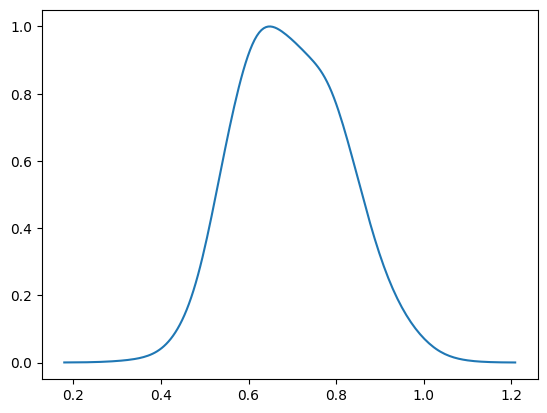

In [14]:
%matplotlib inline
smoothhist(data)